<a href="https://colab.research.google.com/github/gabrie1-s/Chagas_analysis/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Aquisição dos dados

In [ ]:
!pip install --upgrade pip
!pip install mat73
!pip install scikit-learn --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
import mat73
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = mat73.loadmat('/content/drive/MyDrive/CNN_Chagas/Chagas/data/Dataset_Raw.mat')

In [ ]:
signals = list(dataset['Dataset_Raw'])

output = []
for i in range(0, len(signals)):
    output.append(signals[i][-1])
    signals[i] = np.delete(signals[i], [-1,-2])
    # signals[i] = signals[i][0:1000]

In [ ]:
max = 20
for i, signal in enumerate(signals):
  count = 0
  for j, val in enumerate(signal):
    if val == 0:
      count += 1
    else:
      count = 0

    if count == max:
      signals[i] = signal[0: j-max+1]
      break

In [ ]:
d = {'signals': signals, 'output': output}
df = pd.DataFrame(data=d)

# 2. Aplicação da transformada wavelet

In [ ]:
def gera_filtro_MH(Escala):
  passo = 1/Escala
  X = []
  a = -5
  X.append(a)
  while a <= 5:
    a=a+passo
    X.append(a)
  Y = []
  for i in range(0,len(X)):
    Y.append(2.1741*(1/math.sqrt(2*math.pi) * (1 - X[i]**2) * np.exp(-X[i]**2/(2))))
  return Y

def apply_wavelet(signal, level):
  Filtro = gera_filtro_MH(level)
  y = np.convolve(signal,Filtro)
  return y

In [ ]:
test_sig = random.choices(signals, k=5)

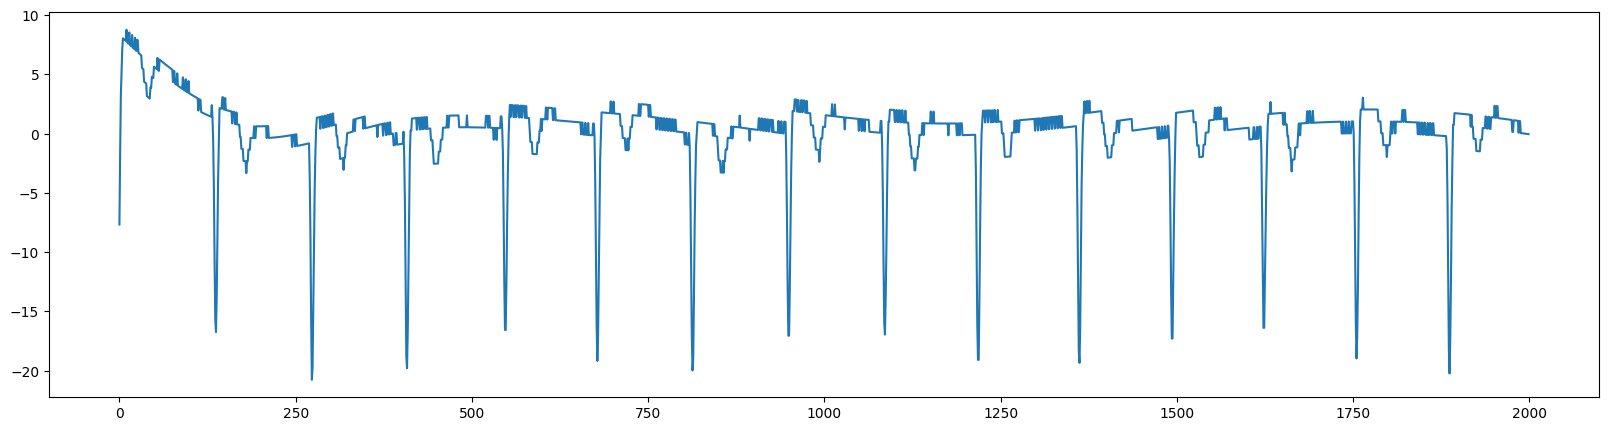

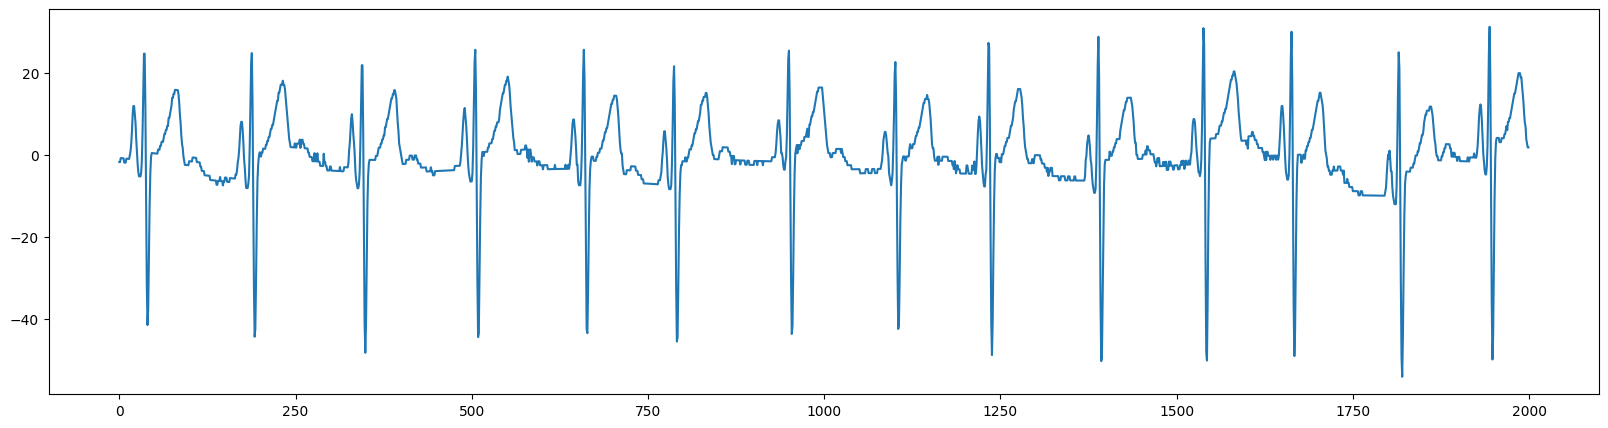

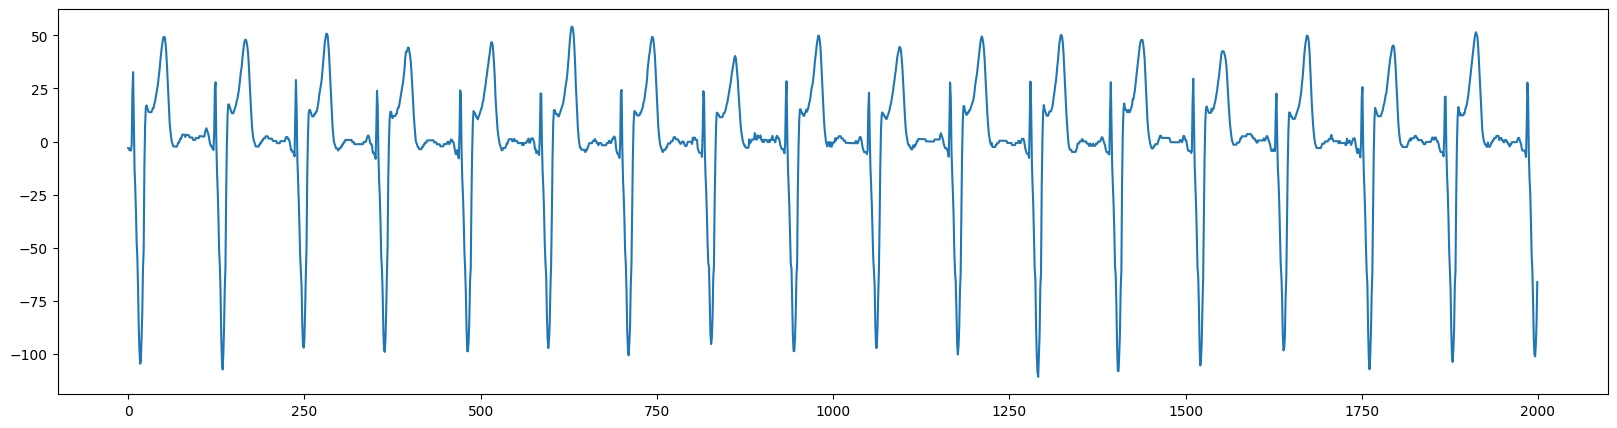

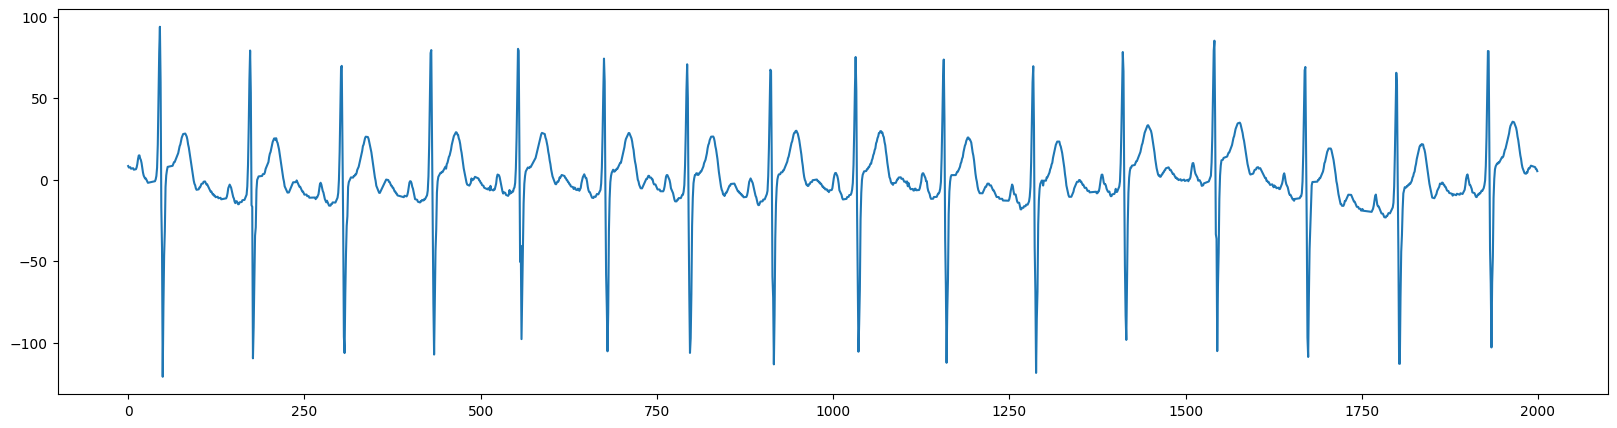

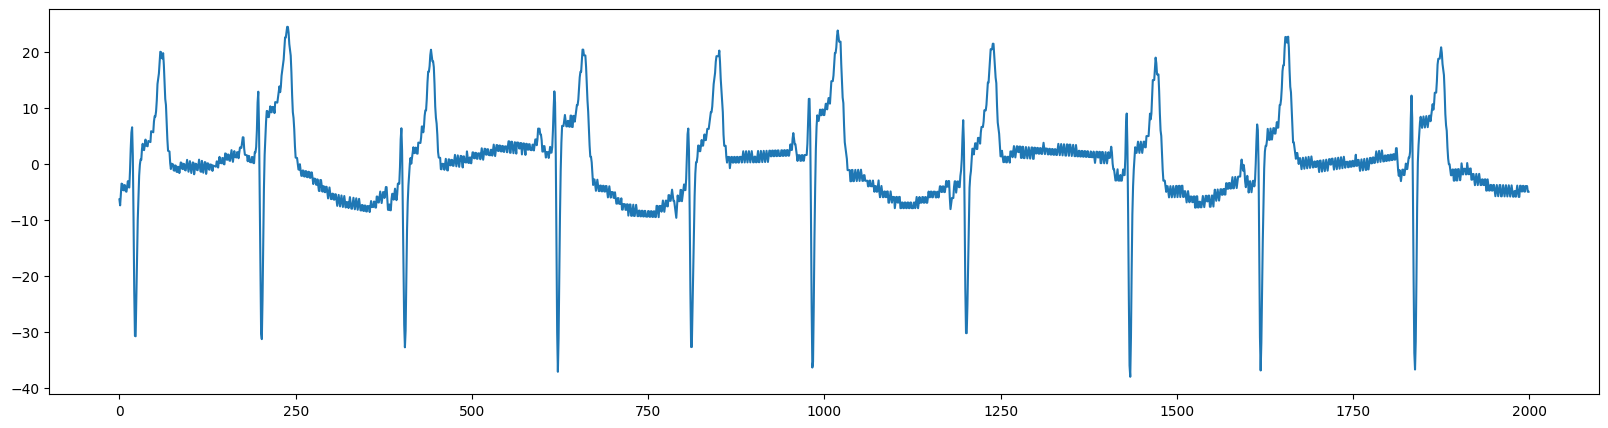

In [ ]:
for i in test_sig:
    plt.rcParams["figure.figsize"] = (20,5)
    plt.plot(i[0:2000])
    plt.show()

In [ ]:
# x = []
# for i in signals:
#   val = apply_wavelet(i, 2**2)
#   x.append(val)
# signals = x

In [ ]:
# for i in test_sig:
#     i = apply_wavelet(i[0:2000], 2)
#     plt.plot(i)
#     plt.show()

### 2.4 Janelamento dos dados de treino

In [ ]:
def discrete_ratio(ratio_set, n):
    classes = list(range(1, n+1))
    ratio = 1.0/n

    for j in range(0, len(ratio_set)):
        for i in range(0, n):
            if ratio_set[j] > ratio*i and ratio_set[j] <= ratio*(i+1):
                ratio_set[j] = int(classes[i])
                break

    return ratio_set

In [ ]:
y = df["output"].copy()
y = discrete_ratio(y, 2)

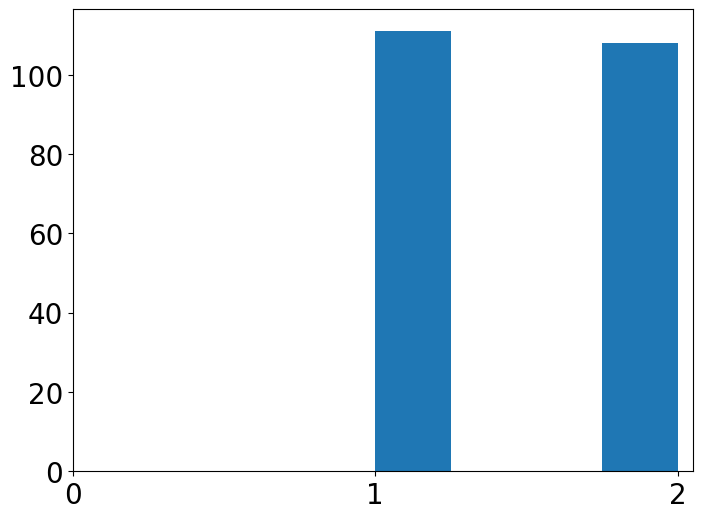

In [ ]:
plt.rcParams.update({'font.size': 20})

y.hist(
    figsize=(8, 6),
    range = [1, 2],
    grid = False,
    bins = 4,
)
plt.xticks(range(3))
plt.show()

In [ ]:
intersection = -100
window_size = 500
interval = 15000
wp_interval = 2
n_windows = "max"

In [ ]:
def window(signal, intersection, window_size, n):
    s_size = len(signal)
    max_n = (s_size-intersection)/(window_size - intersection)
    samples = []

    if  n == "max" or n > max_n:
        n = max_n
        n = math.floor(n)

    max_begin = s_size - (n*(window_size) - (n-1)*intersection) + 1
    init = random.randrange(max_begin)
    for i in range(0, n):
        begin = init + i*window_size - i*intersection
        end = begin + window_size
        samples.append(signal[begin:end])


    return samples

In [ ]:
def random_window(signal, window_size, interval, wp_interval):
  s_size = len(signal)
  n_intervals = math.floor(s_size/interval)

  samples = []
  for i in range(0, n_intervals):
    points = []
    begin = i*interval + math.floor(interval/2) - math.floor(window_size/2)

    samples.append(signal[begin:begin+window_size])
    # for j in range(wp_interval):
    #   count = 0
    #   while True:
    #     new_p = random.randrange(begin, end)

    #     for point in points:
    #       if new_p + window_size >= point and new_p - window_size <= point:
    #         count += 1
    #         break

    #     if count == 0:
    #       points.append(new_p)
    #       break

    # samples += points

    # for i,x in enumerate(samples):
    #   samples[i] = signal[x:x+window_size]

  return samples




In [ ]:
def embalance_data(df, intersection, window_size, n):

  d_train = df.copy()
  d_train = d_train.iloc[0:0]

  for index, row in df.iterrows():
    samples = window(row["signals"], intersection, window_size, n)

    for k in range(len(samples)):
      d_train = d_train.append({'signals': samples[k], 'output': row["output"]}, ignore_index=True)

  return d_train

In [ ]:
def random_df(df, window_size, interval, wp_interval):

  d_train = df.copy()
  d_train = d_train.iloc[0:0]

  for index, row in df.iterrows():
    samples = random_window(row["signals"], window_size, interval, wp_interval)

    for k in range(len(samples)):
      d_train = d_train.append({'signals': samples[k], 'output': row["output"]}, ignore_index=True)

  return d_train

In [ ]:
#x_rem, x_test, y_rem, y_test = train_test_split(signals, y, stratify = y, test_size=0.1)
x_train, x_valid, y_train, y_valid = train_test_split(signals, y, test_size=0.25)

d_aux_train = pd.DataFrame({'signals': x_train, 'output': y_train})
d_train = random_df(d_aux_train, window_size, interval, wp_interval)

d_aux_valid = pd.DataFrame({'signals': x_valid, 'output': y_valid})
d_valid = random_df(d_aux_valid, window_size, interval, wp_interval)

# path = 'drive/MyDrive/CNN_Chagas/Chagas/saves/'

# d_aux_train = pd.read_hdf(path + 'd_aux_train1.h5')
# d_aux_train2 = pd.read_hdf(path + 'd_aux_train2.h5')
# d_aux_train = pd.concat([d_aux_train, d_aux_train2])
# del d_aux_train2

# d_train = pd.read_hdf(path + 'd_train1.h5')
# d_train2 = pd.read_hdf(path + 'd_train2.h5')
# d_train = pd.concat([d_train, d_train2])
# del d_train2

# d_aux_valid = pd.read_hdf(path + 'd_aux_valid.h5')
# d_valid = pd.read_hdf(path + 'd_valid.h5')

A saída de streaming foi truncada nas últimas 5000 linhas.
<ipython-input-20-90b1ad920874>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d_train = d_train.append({'signals': samples[k], 'output': row["output"]}, ignore_index=True)
<ipython-input-20-90b1ad920874>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d_train = d_train.append({'signals': samples[k], 'output': row["output"]}, ignore_index=True)
<ipython-input-20-90b1ad920874>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d_train = d_train.append({'signals': samples[k], 'output': row["output"]}, ignore_index=True)
<ipython-input-20-90b1ad920874>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

In [ ]:
d_train

,signals,output
0,"[1.200975, 1.21227, -5.77638, -18.764975, -31....",1.0
1,"[20.882596, 20.741975, 21.605418, 21.472949, 2...",1.0
2,"[-5.501127, -5.493192, -4.485233, -2.477249, 1...",1.0
3,"[2.000149, 1.99982, 1.999585, 0.999445, 0.9993...",1.0
4,"[-3.445441, -3.445871, -2.446323, -3.446797, -...",1.0
...,...,...
16567,"[144.0, 144.0, 144.0, 144.0, 144.0, 144.0, 144...",2.0
16568,"[148.0, 150.0, 152.0, 153.0, 154.0, 154.0, 153...",2.0
16569,"[144.0, 144.0, 145.0, 146.0, 148.0, 149.0, 148...",2.0
16570,"[138.0, 138.0, 139.0, 141.0, 143.0, 144.0, 145...",2.0


In [ ]:
# def convert_hdf(data, path, n):
#     end = len(data["signals"])
#     step = math.floor(end/n)
#     flag = False
#     count = 0

#     for i in range(0, end, step):
#         count += 1
#         init = i
#         fim = i+1

#         if fim >= end:
#             fim = end
#             flag = True

#         val = data.loc[init:fim]
#         val.to_hdf(path + str(count) + '.h5', 'df')
#         print(i)
#         if flag == True:
#             break

In [ ]:
# d_aux_train = d_aux_train.reset_index(drop=True)

In [ ]:
# convert_hdf(d_aux_train, 'd_aux_train', 1)
# convert_hdf(d_train, 'd_train', 1)

# d_aux_valid.to_hdf('d_aux_valid.h5', 'df')
# d_valid.to_hdf('d_valid.h5', 'df')

In [ ]:
# len(d_train)

# 3. Implementação da CNN

### 3.1 Descoberta dos hyperparâmetros (Otimização Bayseana)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D

from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from sklearn.utils import shuffle
from math import floor

In [ ]:
d_train.sample(frac=1)
d_valid.sample(frac=1)

,signals,output
3845,"[-5.723253, -5.738323, -5.753099, -5.767578, -...",2.0
187,"[9.62522, 8.633502, 0.641718, -7.350131, -11.3...",2.0
4514,"[-19.856575, -19.849173, -18.84174, -15.834275...",2.0
2945,"[-0.766413, -0.763127, -0.760003, -0.757041, -...",2.0
965,"[-5.680011, -5.697683, -4.715412, -4.733193, -...",2.0
...,...,...
996,"[1.783097, 1.75865, 1.734556, 1.710818, 1.6874...",2.0
2235,"[-2.408665, -2.424991, -2.441421, -2.457953, -...",2.0
2735,"[-4.709052, -4.702378, -5.695749, -5.689165, -...",1.0
3379,"[12.295404, 13.288243, 12.281107, 11.273997, 1...",1.0


In [ ]:
y_train = d_train["output"].copy()
y_valid = d_valid["output"].copy()

In [ ]:
x_train = np.array(list(d_train["signals"]))
x_valid = np.array(list(d_valid["signals"]))

### 3.1.2 Import packages

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.metrics import make_scorer, accuracy_score, mean_squared_error, classification_report

pd.set_option("display.max_columns", None)

from sklearn import metrics
import tensorflow as tf

In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def print_history(history, classificador, x_valid, y_valid, columns):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    #plt.savefig('plot '+classe+'.png')
    plt.show()

    y_pred = classificador.predict(x_valid)
    y_pred = pd.DataFrame(y_pred)
    y_pred.columns = columns

    y_pred = y_pred.idxmax(axis=1)
    relatorio = classification_report(y_valid, y_pred)
    print(relatorio)

In [ ]:
def create_cnn(x_train, y_train, x_valid, y_valid, optimizer):

    #x_train = np.array(list(x_train))
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    y_train = pd.get_dummies(y_train)

    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], 1)
    y_valid = pd.get_dummies(y_valid)

    print(y_train.columns)

    input_shape = len(x_train[0])
    k1 = 5
    k2 = 3

    classificador = Sequential()


    classificador.add(Conv1D(filters=128, kernel_size = k1, input_shape = (input_shape, 1), activation = "relu"))
    classificador.add(Conv1D(filters=128, kernel_size = k1, activation = "relu"))
    classificador.add(MaxPooling1D(pool_size=2))
    # BatchNormalization()

    classificador.add(Conv1D(filters=256, kernel_size = k2, activation = "relu"))
    # BatchNormalization()
    classificador.add(Conv1D(filters=256, kernel_size = k2, activation = "relu"))
    classificador.add(MaxPooling1D(pool_size=2))

    classificador.add(Flatten())

    classificador.add(Dense(units=64, activation='relu'))
    classificador.add(Dropout(0.5))
    classificador.add(Dense(units=32, activation='relu'))
    classificador.add(Dropout(0.5))
    classificador.add(Dense(units=16, activation='relu'))
    classificador.add(Dropout(0.5))

    classificador.add(Dense(2, activation="softmax"))

    classificador.compile(loss='categorical_crossentropy', optimizer=optimizer(learning_rate=0.01), metrics=["accuracy"])

    es = EarlyStopping(monitor="val_accuracy", mode='max', verbose=0, patience=15)

    checkpoint = ModelCheckpoint('_pesos_cnn1d.hdf5', monitor="val_accuracy", verbose=1,
                                      save_best_only=True, mode='max')

    history = classificador.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=50,
                                batch_size=128, callbacks=[checkpoint], verbose=1)

    return y_train.columns, classificador, history

<class 'keras.optimizers.adamax.Adamax'>
Float64Index([1.0, 2.0], dtype='float64')
Epoch 1/50
130/130 [==============================] - ETA: 0s - loss: 2.7057 - accuracy: 0.4970
Epoch 1: val_accuracy improved from -inf to 0.50723, saving model to _pesos_cnn1d.hdf5
130/130 [==============================] - 8s 42ms/step - loss: 2.7057 - accuracy: 0.4970 - val_loss: 0.6930 - val_accuracy: 0.5072
Epoch 2/50
130/130 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5110
Epoch 2: val_accuracy did not improve from 0.50723
130/130 [==============================] - 5s 40ms/step - loss: 0.6930 - accuracy: 0.5110 - val_loss: 0.6932 - val_accuracy: 0.5041
Epoch 3/50
129/130 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5111
Epoch 3: val_accuracy did not improve from 0.50723
130/130 [==============================] - 5s 40ms/step - loss: 0.6930 - accuracy: 0.5112 - val_loss: 0.6933 - val_accuracy: 0.5072
Epoch 4/50
129/130 [========================

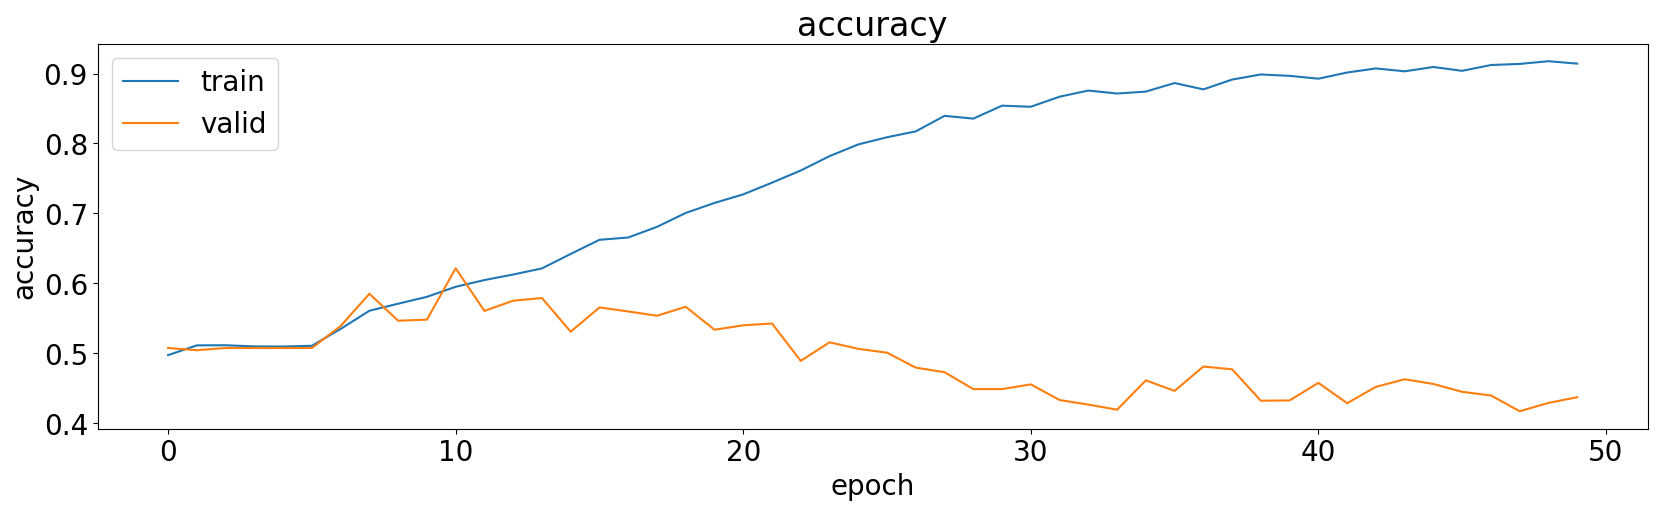

158/158 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

         1.0       0.43      0.44      0.43      2489
         2.0       0.44      0.44      0.44      2562

    accuracy                           0.44      5051
   macro avg       0.44      0.44      0.44      5051
weighted avg       0.44      0.44      0.44      5051



In [ ]:
for i in  [Adamax]:
  print(str(i))
  columns, classificador, history = create_cnn(x_train, y_train, x_valid, y_valid, i)
  print_history(history, classificador, x_valid, y_valid, columns)

In [ ]:
def build_tree(x_train, y_train, x_valid, y_valid, classes_array, father):

  if len(classes_array) < 2:
    print("impossivel classificar")
    return

  minority = classes_array[0]
  del classes_array[0]

  if len(classes_array) != 1:
    y_next = y_train.replace(classes_array, "nan")
    y_next_val = y_valid.replace(classes_array, "nan")
  else:
    y_next = y_train
    y_next_val = y_valid

  columns, model, history = create_cnn(x_train, y_next, x_valid, y_next_val)
  node = BinaryTreeNode(model=model, classe="nan")
  node.leftChild = BinaryTreeNode(model=None, classe=minority)
  node.columns = columns

  print_history(history, minority, model, x_valid, y_next_val, columns)

  if type(father) == RootNode:
    father.child = node
  else:
    father.rightChild = node

  if len(classes_array) == 1:
    node.rightChild = BinaryTreeNode(model=None, classe=classes_array[0])
  else:
    aux_df = pd.DataFrame({"signals": list(x_train), "classes": y_train})
    aux_df_valid = pd.DataFrame({"signals": list(x_valid), "classes": y_valid})

    aux_df.drop(aux_df[aux_df['classes'] == minority].index, inplace=True)
    aux_df_valid.drop(aux_df_valid[aux_df_valid['classes'] == minority].index, inplace=True)

    x_next = np.array(list(aux_df["signals"]))
    x_next_val = np.array(list(aux_df_valid["signals"]))

    y_next = aux_df["classes"]
    y_next_val = aux_df_valid["classes"]

    build_tree(x_next, y_next, x_next_val, y_next_val, classes_array, node)


# 4. Verificando  a precisão com os dados de teste

In [ ]:
y_pred = []
for signal in x_test:
  samples = window(signal, intersection, window_size, "max")
  samples = np.array(samples)
  samples = samples.reshape(samples.shape[0],samples.shape[1], 1)

  prediction = model.predict(samples)
  val = prediction.mean()
  y_pred.append(val)

In [ ]:
print(mean_squared_error(y_test, y_pred))

In [ ]:
x1 = range(0, len(y_test))
x2 = range(0, len(y_pred))

test = plt.scatter(x1, y_test, s = 70)
pred = plt.scatter(x2, y_pred, s = 70)

plt.legend((test, pred),
            ("Real", "Predito"),
            loc='lower left',
        )

plt.savefig("result.png")